In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import collections

## Preprocessing

In [2]:
annotator_responses = pd.read_json('./Data/anonymized_project.json')
annotator_responses.head()

,results
root_node,"{'gui_type': 'discrete_answer', 'results': {'7..."


First, I have loaded the json file and looked at the head of the panda object. From here, I can see that there is results column and only one row which is root_node. So next, I looked into the data.

In [3]:
annotator_responses['results']['root_node'].keys()

dict_keys(['gui_type', 'results'])

After looking at the cell of the table, I can see that it is a dictionary with two keys which are 'gui_type' and 'results'. The value of 'gui_type' is 'discrete_answer' and I am assuming that it is the type of answer for this specific dataset. Here, the 'results' is the key which contains the important dataset so I look into it more

In [4]:
annotator_responses['results']['root_node']['results']['7e8984b6-dff7-4015-865a-b721a2faf681']

{'results': [{'task_input': {'image_url': 'https://qm-auto-annotator.s3.eu-central-1.amazonaws.com/bicycles/img_4686.jpg'},
   'created_at': '2021-02-25T14:08:11.319438+00:00',
   'workpackage_total_size': 5,
   'loss': 0.0,
   'project_node_input_id': '7e8984b6-dff7-4015-865a-b721a2faf681',
   'project_node_output_id': '0000439a-96ac-4bd4-8753-a4baa229ecf2',
   'task_output': {'answer': 'no',
    'cant_solve': False,
    'corrupt_data': False,
    'duration_ms': 997},
   'user': {'vendor_id': 'vendor_01',
    'id': '08af8775-a72c-4c59-b60f-9ce7df04fa92',
    'vendor_user_id': 'annotator_12'},
   'root_input': {'image_url': 'https://qm-auto-annotator.s3.eu-central-1.amazonaws.com/bicycles/img_4686.jpg'},
   'project_root_node_input_id': '7e8984b6-dff7-4015-865a-b721a2faf681'},
  {'task_input': {'image_url': 'https://qm-auto-annotator.s3.eu-central-1.amazonaws.com/bicycles/img_4686.jpg'},
   'created_at': '2021-02-25T13:14:39.411149+00:00',
   'workpackage_total_size': 5,
   'loss': 0.0

In [5]:
list(annotator_responses['results']['root_node']['results'].keys())[0:3]

['7e8984b6-dff7-4015-865a-b721a2faf681',
 '9d8a2527-accb-40bd-90d8-a73f20a609be',
 '0625d00c-96c3-41ad-9324-37037ffd0325']

In [6]:
len(annotator_responses['results']['root_node']['results'].keys())

9087

At this point, I can see that results contain 9087 keys which would correspond to the number of images shown to the annotators. Next, I am going to look at the result of single image.

In [7]:
annotator_responses_dictionary = annotator_responses['results']['root_node']['results']

In [8]:
annotator_responses_dictionary[list(annotator_responses_dictionary.keys())[0]]

{'results': [{'task_input': {'image_url': 'https://qm-auto-annotator.s3.eu-central-1.amazonaws.com/bicycles/img_4686.jpg'},
   'created_at': '2021-02-25T14:08:11.319438+00:00',
   'workpackage_total_size': 5,
   'loss': 0.0,
   'project_node_input_id': '7e8984b6-dff7-4015-865a-b721a2faf681',
   'project_node_output_id': '0000439a-96ac-4bd4-8753-a4baa229ecf2',
   'task_output': {'answer': 'no',
    'cant_solve': False,
    'corrupt_data': False,
    'duration_ms': 997},
   'user': {'vendor_id': 'vendor_01',
    'id': '08af8775-a72c-4c59-b60f-9ce7df04fa92',
    'vendor_user_id': 'annotator_12'},
   'root_input': {'image_url': 'https://qm-auto-annotator.s3.eu-central-1.amazonaws.com/bicycles/img_4686.jpg'},
   'project_root_node_input_id': '7e8984b6-dff7-4015-865a-b721a2faf681'},
  {'task_input': {'image_url': 'https://qm-auto-annotator.s3.eu-central-1.amazonaws.com/bicycles/img_4686.jpg'},
   'created_at': '2021-02-25T13:14:39.411149+00:00',
   'workpackage_total_size': 5,
   'loss': 0.0

In [9]:
annotator_responses_dictionary[list(annotator_responses_dictionary.keys())[0]]['results'][0]

{'task_input': {'image_url': 'https://qm-auto-annotator.s3.eu-central-1.amazonaws.com/bicycles/img_4686.jpg'},
 'created_at': '2021-02-25T14:08:11.319438+00:00',
 'workpackage_total_size': 5,
 'loss': 0.0,
 'project_node_input_id': '7e8984b6-dff7-4015-865a-b721a2faf681',
 'project_node_output_id': '0000439a-96ac-4bd4-8753-a4baa229ecf2',
 'task_output': {'answer': 'no',
  'cant_solve': False,
  'corrupt_data': False,
  'duration_ms': 997},
 'user': {'vendor_id': 'vendor_01',
  'id': '08af8775-a72c-4c59-b60f-9ce7df04fa92',
  'vendor_user_id': 'annotator_12'},
 'root_input': {'image_url': 'https://qm-auto-annotator.s3.eu-central-1.amazonaws.com/bicycles/img_4686.jpg'},
 'project_root_node_input_id': '7e8984b6-dff7-4015-865a-b721a2faf681'}

I have saved the keys and the dictionary seperately so that I could access it more easily. From the detailed single data, I can see that there is another dictionary with single key 'results' and it contains array. If we look at the single element of that array, we can see the image_url, task_output and the id of the annotator etc. To sum it up, we have a dictionary with each image data, and inside each dictionary value, we have array of answers from each of the annotators.

Now, that I have understood the structure of the dataset, I will go into the analysis task of the challenge.

First, I will take the necessary info from annotator_responses_dictionary and put it into different dictionaries. First, I make a dictionary with key of the annotator_id and put every answer the annotator answered as value. Next, I make dictionaries based on the image_id as key and answer, corrupt_data and cant_solve as values.

In [10]:
annotators_answer = dict() # dictionary with annotator id as key and answers for value

answer_categorized_by_image_id = dict() # dictionary with image id as key and answers, cant_solve, corrupt_data as value

for key in annotator_responses_dictionary: # I am iterating the keys of the original annotator_responses_dictionary 
     # inside a project input id, the value is all the annotators that has answered for this image
    all_annotators_results = annotator_responses_dictionary[key]['results']
    
    for single_annotator_result in all_annotators_results: # I iterate through all the annotators that has answered for this image
        
        annotator_id = single_annotator_result['user']['vendor_user_id']
        
        if not annotator_id in annotators_answer: # If there is no key in the annotators_answer, I make an empty dictionary
            annotators_answer[annotator_id] = dict()
        
        # I make a empty list for each of the variables such as node_input_id, image_id, answer, corrupt_data, cant_solve,
        # and duration_ms.
        
        if not 'node_input_id_list' in annotators_answer[annotator_id]:
            annotators_answer[annotator_id]['node_input_id_list'] = np.array([])
        
        if not 'image_id' in annotators_answer[annotator_id]:
            annotators_answer[annotator_id]['image_id'] = np.array([])
        
        if not 'answer_list' in annotators_answer[annotator_id]:
            annotators_answer[annotator_id]['answer_list'] = np.array([])
        
        if not 'corrupt_data_list' in annotators_answer[annotator_id]:
            annotators_answer[annotator_id]['corrupt_data_list'] = np.array([])
            
        if not 'cant_solve_list' in annotators_answer[annotator_id]:
            annotators_answer[annotator_id]['cant_solve_list'] = np.array([])
            
        if not 'duration_ms_list' in annotators_answer[annotator_id]:
            annotators_answer[annotator_id]['duration_ms_list'] = np.array([])
        
        # After making the empty array value for each key, I append the values to the arrays
        
        annotators_answer[annotator_id]['node_input_id_list'] = np.append(
            annotators_answer[annotator_id]['node_input_id_list'], 
            single_annotator_result['project_node_input_id'])
        
        annotators_answer[annotator_id]['answer_list'] = np.append(
            annotators_answer[annotator_id]['answer_list'], 
            single_annotator_result['task_output']['answer'])
        
        annotators_answer[annotator_id]['corrupt_data_list'] = np.append(
            annotators_answer[annotator_id]['corrupt_data_list'], 
            single_annotator_result['task_output']['corrupt_data'])
        
        annotators_answer[annotator_id]['cant_solve_list'] = np.append(
            annotators_answer[annotator_id]['cant_solve_list'], 
            single_annotator_result['task_output']['cant_solve'])
        
        annotators_answer[annotator_id]['duration_ms_list'] = np.append(
            annotators_answer[annotator_id]['duration_ms_list'], 
            single_annotator_result['task_output']['duration_ms'])
        
        # In order to get only the image id from image url, I used replace and split functions.
        # The image id is usefull to access reference.json file later.
        image_id = single_annotator_result['task_input']['image_url'].replace('.','/').split('/')[-2]
        
        annotators_answer[annotator_id]['image_id'] = np.append(
            annotators_answer[annotator_id]['image_id'], 
            image_id)
        
        # I made another dictionary, that uses image id as key and answers for the value which is used to answer 
        # overall questions regarding the images.
        
        if not image_id in answer_categorized_by_image_id:
            answer_categorized_by_image_id[image_id] = np.array([])
                
        answer_categorized_by_image_id[image_id] = np.append(
            answer_categorized_by_image_id[image_id],
            single_annotator_result['task_output']['answer'])
        
        

Next, I sorted the annotator dictionary to make simpler to see.

In [11]:
# I am sorting the annotators_answer dictionary from annotator_01 to annotator_22
annotators_answer = collections.OrderedDict(sorted(annotators_answer.items()))

In [12]:
annotators_answer.keys()

odict_keys(['annotator_01', 'annotator_02', 'annotator_03', 'annotator_04', 'annotator_05', 'annotator_06', 'annotator_07', 'annotator_08', 'annotator_09', 'annotator_10', 'annotator_11', 'annotator_12', 'annotator_13', 'annotator_14', 'annotator_15', 'annotator_16', 'annotator_17', 'annotator_18', 'annotator_19', 'annotator_20', 'annotator_21', 'annotator_22'])

## Task 1.

### 1.a)

In [13]:
# Since I used annotator_id as key in annotators_answer dictionary,
# the total number of keys is same as the number of annotator

print('Total number of annotators: {}'.format(len(annotators_answer.keys())))

Total number of annotators: 22


The total number of annotators are 22

### 1.b)

First, I looked into the values of the duration but annotator 19 had a duration less than 0 as shown below.

In [14]:
# some values of the duration_ms is less than 0
annotators_answer['annotator_19']['duration_ms_list']<0

array([ True,  True,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

annotator_01 max: 5120.0 min: 526.0 ave: 1077.3234375
annotator_02 max: 24856.0 min: 447.0 ave: 1178.1700895208005
annotator_03 max: 24190.0 min: 503.0 ave: 1460.2492063492064
annotator_04 max: 19158.0 min: 10.0 ave: 1113.926958417692
annotator_05 max: 23037.0 min: 263.0 ave: 1562.0892086330934
annotator_06 max: 42398.0 min: 615.0 ave: 1496.9402173913043
annotator_07 max: 27727.0 min: 525.0 ave: 1578.3622988505747
annotator_08 max: 33326.0 min: 166.0 ave: 1434.5129264188465
annotator_09 max: 37428.0 min: 534.0 ave: 1198.8141975308642
annotator_10 max: 37995.0 min: 472.0 ave: 1252.974603174603
annotator_11 max: 41703.0 min: 302.0 ave: 1279.9106587942822
annotator_12 max: 31780.0 min: 149.0 ave: 1306.3054750402578
annotator_13 max: 24000.0 min: 470.0 ave: 1155.0111613450126
annotator_14 max: 25488.0 min: 444.0 ave: 1594.9089855072464
annotator_15 max: 28760.0 min: 231.0 ave: 1365.2917214191853
annotator_16 max: 35880.0 min: 575.0 ave: 1269.7931238885596
annotator_17 max: 13233.0 min: 421

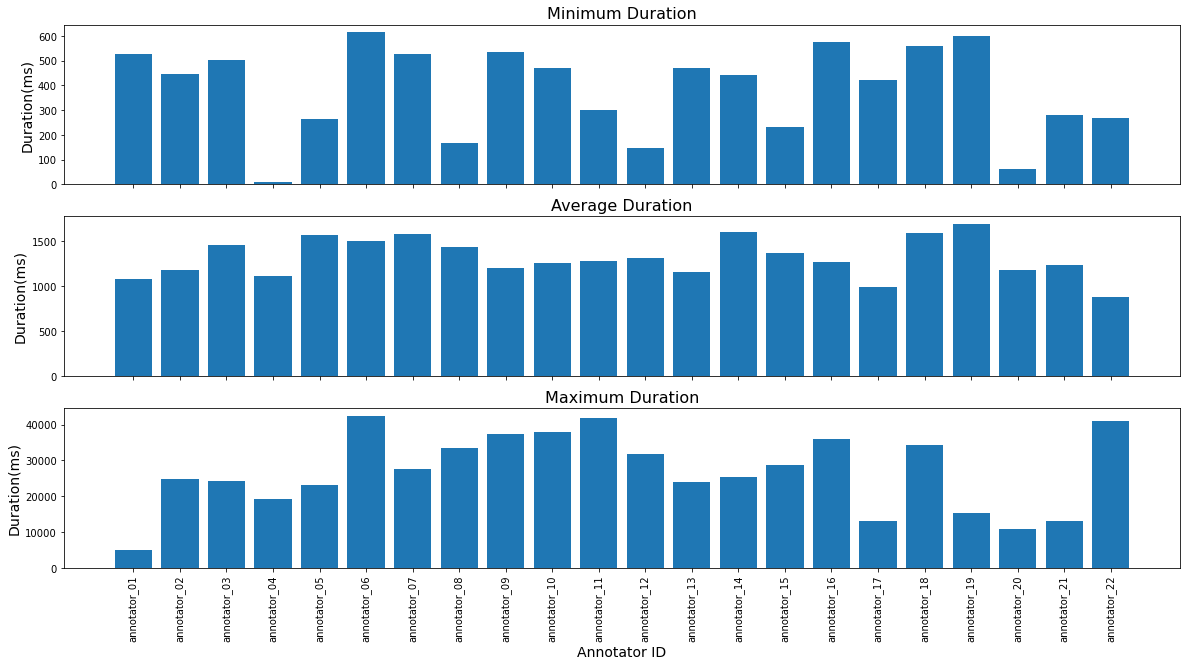

In [31]:
# I have made empty arrays in order to store minimum, maximum, and average duration of each annotator.
min_durs_list = np.array([])
ave_durs_list = np.array([])
max_durs_list = np.array([])

for annotator in annotators_answer: # I am iterating through the annotators
            
    # I remove the duration values which is less than 0, and stored it in durations_with_only_positive_val
    durations_with_only_positive_val = annotators_answer[annotator]['duration_ms_list']\
                                                        [annotators_answer[annotator]['duration_ms_list']>0]
    
    # I am calculating minimum, maximum and average values of duration using numpy's function min(), max(), and mean()
    min_durtaion = durations_with_only_positive_val.min()
    ave_durtaion = durations_with_only_positive_val.mean()
    max_duration = durations_with_only_positive_val.max()
    
    # I am appending the minimum, maximum and average values to the numpy array
    min_durs_list = np.append(min_durs_list, min_durtaion)
    ave_durs_list = np.append(ave_durs_list, ave_durtaion)
    max_durs_list = np.append(max_durs_list, max_duration)
    
    print('{} max: {} min: {} ave: {}'.format(annotator, max_duration, min_durtaion, ave_durtaion))    
    
# Here I am plotting the minimum, maximum and average values for each annotators
    
fig, axs = plt.subplots(3, sharex=True, figsize=(20, 10))
        
axs[0].bar(np.arange(len(annotators_answer)), min_durs_list)
axs[0].set_ylabel("Duration(ms)", size=14)
axs[0].set_title('Minimum Duration', size=16)

axs[1].bar(np.arange(len(annotators_answer)), ave_durs_list)
axs[1].set_ylabel("Duration(ms)", size=14)
axs[1].set_title('Average Duration', size=16)

axs[2].bar(np.arange(len(annotators_answer)), max_durs_list)
axs[2].set_ylabel("Duration(ms)", size=14)
axs[2].set_title('Maximum Duration', size=16)

plt.xticks(np.arange(len(annotators_answer)), list(annotators_answer.keys()), rotation='vertical')
plt.xlabel("Annotator ID", size=14)

# fig.savefig('MinAveMaxDurations.png', bbox_inches='tight')

### 1.c)

In [34]:
amount_of_results_annotators = np.array([])
# I am iterating through the annotars and print the length of answers for each annotator
for annotator in annotators_answer:
    
    amount_of_results_annotators = np.append(amount_of_results_annotators,\
                                             len(annotators_answer[annotator]['node_input_id_list']))
    print("Amount of results for",annotator," :",len(annotators_answer[annotator]['node_input_id_list']))
    
    

Amount of results for annotator_01  : 1280
Amount of results for annotator_02  : 7596
Amount of results for annotator_03  : 630
Amount of results for annotator_04  : 6421
Amount of results for annotator_05  : 3475
Amount of results for annotator_06  : 5337
Amount of results for annotator_07  : 2175
Amount of results for annotator_08  : 6537
Amount of results for annotator_09  : 4860
Amount of results for annotator_10  : 315
Amount of results for annotator_11  : 6436
Amount of results for annotator_12  : 6210
Amount of results for annotator_13  : 7078
Amount of results for annotator_14  : 1725
Amount of results for annotator_15  : 6088
Amount of results for annotator_16  : 5061
Amount of results for annotator_17  : 3485
Amount of results for annotator_18  : 5170
Amount of results for annotator_19  : 170
Amount of results for annotator_20  : 6126
Amount of results for annotator_21  : 2950
Amount of results for annotator_22  : 1745


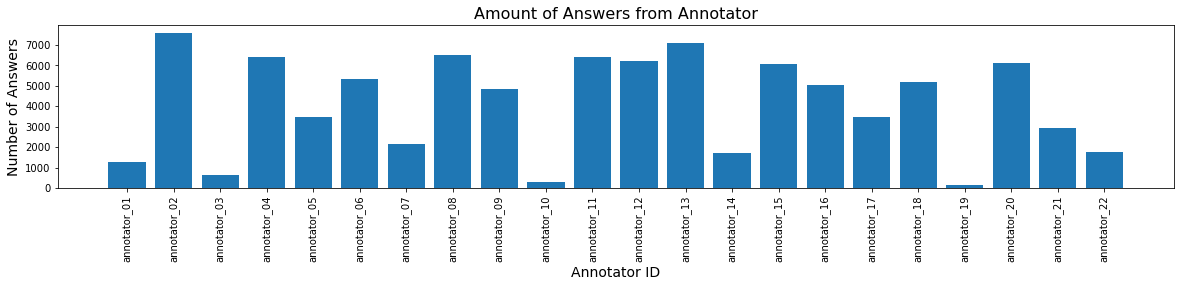

In [38]:
plt.rcParams["figure.figsize"] = (20,3)
plt.bar(np.arange(len(annotators_answer)), amount_of_results_annotators)
plt.ylabel("Number of Answers", size=14)
plt.title('Amount of Answers from Annotator', size=16)
plt.xticks(np.arange(len(annotators_answer)), list(annotators_answer.keys()), rotation='vertical')
plt.xlabel("Annotator ID", size=14)

plt.savefig('AmountOfAnswersAnnotators.png', bbox_inches='tight')

As can be seen above, each annotator answered different number of questions.

### 1.d)

I am using the dictionary answer_categorized_by_image_id to get the answers for each images. The meaning of disagreeing is that the annotators have answer NO and YES almost equally otherwise it would mean they agree mostly.

In [41]:
counter = 0
for image_id in answer_categorized_by_image_id:
    
    # I find the number of no answers and divide by total number of answers to get the frequency of answer NO
    freq_of_no_answer = np.sum(answer_categorized_by_image_id[image_id] == 'no')\
                            /len(answer_categorized_by_image_id[image_id]) 
    # By subtracting from 1, we can get the frequency of YES answer
    freq_of_yes_answer = 1 - freq_of_no_answer
    
    # The meaning of disagreeing is that the annotators have answer NO and YES almost equally 
    # otherwise it would mean they agree mostly.
    if abs(freq_of_no_answer - freq_of_yes_answer) <= 0.2:
        print("Image ID: ", image_id, "Frequency of NO answer: ", freq_of_no_answer)
        print("Image ID: ", image_id, "Frequency of YES answer: ", freq_of_yes_answer,'\n')
        counter += 1
        
#     if counter == 10:
#         break

print(counter)

Image ID:  img_5552 Frequency of NO answer:  0.4
Image ID:  img_5552 Frequency of YES answer:  0.6 

Image ID:  img_6356 Frequency of NO answer:  0.6
Image ID:  img_6356 Frequency of YES answer:  0.4 

Image ID:  img_3323 Frequency of NO answer:  0.4
Image ID:  img_3323 Frequency of YES answer:  0.6 

Image ID:  img_4905 Frequency of NO answer:  0.6
Image ID:  img_4905 Frequency of YES answer:  0.4 

Image ID:  img_7533 Frequency of NO answer:  0.5
Image ID:  img_7533 Frequency of YES answer:  0.5 

Image ID:  img_0341 Frequency of NO answer:  0.6
Image ID:  img_0341 Frequency of YES answer:  0.4 

Image ID:  img_7502 Frequency of NO answer:  0.5
Image ID:  img_7502 Frequency of YES answer:  0.5 

Image ID:  img_8600 Frequency of NO answer:  0.4
Image ID:  img_8600 Frequency of YES answer:  0.6 

Image ID:  img_2264 Frequency of NO answer:  0.4
Image ID:  img_2264 Frequency of YES answer:  0.6 

Image ID:  img_4428 Frequency of NO answer:  0.4
Image ID:  img_4428 Frequency of YES answe

Image ID:  img_2168 Frequency of YES answer:  0.4 

Image ID:  img_5700 Frequency of NO answer:  0.5
Image ID:  img_5700 Frequency of YES answer:  0.5 

Image ID:  img_6864 Frequency of NO answer:  0.5
Image ID:  img_6864 Frequency of YES answer:  0.5 

Image ID:  img_6709 Frequency of NO answer:  0.4
Image ID:  img_6709 Frequency of YES answer:  0.6 

Image ID:  img_7190 Frequency of NO answer:  0.5
Image ID:  img_7190 Frequency of YES answer:  0.5 

Image ID:  img_0429 Frequency of NO answer:  0.6
Image ID:  img_0429 Frequency of YES answer:  0.4 

Image ID:  img_5469 Frequency of NO answer:  0.5
Image ID:  img_5469 Frequency of YES answer:  0.5 

Image ID:  img_7143 Frequency of NO answer:  0.5
Image ID:  img_7143 Frequency of YES answer:  0.5 

Image ID:  img_2654 Frequency of NO answer:  0.4
Image ID:  img_2654 Frequency of YES answer:  0.6 

Image ID:  img_7455 Frequency of NO answer:  0.5
Image ID:  img_7455 Frequency of YES answer:  0.5 

Image ID:  img_2857 Frequency of NO ans

From the results, we can see that there are multiple cases the annotators answer in highly disagreeing manner.

## Task 2.

For this task we are interested in the cases only where the annotator used either corrupt_data or cant_solve options.
Therefore, we need to get the intersection between corrupt_data or cant_solve.

In [49]:
images_with_cant_solve = dict()
images_with_corrut_data = dict()

for annotator in annotators_answer: # I am iterating through the annotators
    
    # I am finding the indeces where either the cant_solve or corrupt_data options are used.
    intersection_cant_solve_corrupt_data = np.logical_or(annotators_answer[annotator]['cant_solve_list'] == 1,\
                                                         annotators_answer[annotator]['corrupt_data_list'] == 1)
    
    # I have split the cases where either the cant_solve or corrupt_data options are used
    corrupt_data_list_split = annotators_answer[annotator]['corrupt_data_list'][intersection_cant_solve_corrupt_data]
    cant_solve_list_split = annotators_answer[annotator]['cant_solve_list'][intersection_cant_solve_corrupt_data]
    
    image_id_cant_solve = annotators_answer[annotator]['image_id'][annotators_answer[annotator]['cant_solve_list'] == 1]
    image_id_corrupt_data = annotators_answer[annotator]['image_id'][annotators_answer[annotator]['corrupt_data_list'] == 1]
    
    for ids in image_id_cant_solve:
        if ids in images_with_cant_solve:
            images_with_cant_solve[ids] += 1
        else:
            images_with_cant_solve[ids] = 1
            
    for ids in image_id_corrupt_data:
        if ids in images_with_corrut_data:
            images_with_corrut_data[ids] += 1
        else:
            images_with_corrut_data[ids] = 1
            
    
    if np.sum(intersection_cant_solve_corrupt_data) != 0: 
        # if there is use case of either options, we find the matching cases of the two options
        simple_matching = np.sum(cant_solve_list_split == corrupt_data_list_split)/len(intersection_cant_solve_corrupt_data)
        
        print("{} - Trend(cant solve-corrupt data): {}\n".format(annotator, simple_matching))
        
    else: # if there is no use case of either options, I print a message
        print("{} - didn't use cant_solve or corrupt_data options\n".format(annotator))
    

annotator_01 - didn't use cant_solve or corrupt_data options

annotator_02 - Trend(cant solve-corrupt data): 0.0

annotator_03 - didn't use cant_solve or corrupt_data options

annotator_04 - Trend(cant solve-corrupt data): 0.0

annotator_05 - didn't use cant_solve or corrupt_data options

annotator_06 - Trend(cant solve-corrupt data): 0.0

annotator_07 - Trend(cant solve-corrupt data): 0.0

annotator_08 - Trend(cant solve-corrupt data): 0.0

annotator_09 - didn't use cant_solve or corrupt_data options

annotator_10 - didn't use cant_solve or corrupt_data options

annotator_11 - Trend(cant solve-corrupt data): 0.0

annotator_12 - didn't use cant_solve or corrupt_data options

annotator_13 - didn't use cant_solve or corrupt_data options

annotator_14 - Trend(cant solve-corrupt data): 0.0

annotator_15 - didn't use cant_solve or corrupt_data options

annotator_16 - didn't use cant_solve or corrupt_data options

annotator_17 - didn't use cant_solve or corrupt_data options

annotator_18 - T

In [50]:
for image_id in images_with_cant_solve:
    print('{} has {} cant_solve options'.format(image_id, images_with_cant_solve[image_id]))

img_5150 has 1 cant_solve options
img_6982 has 1 cant_solve options
img_4374 has 1 cant_solve options
img_4026 has 1 cant_solve options
img_1752 has 1 cant_solve options
img_6009 has 1 cant_solve options
img_1465 has 1 cant_solve options
img_8804 has 1 cant_solve options
img_2191 has 1 cant_solve options
img_6156 has 1 cant_solve options
img_2451 has 1 cant_solve options
img_0879 has 1 cant_solve options
img_1963 has 1 cant_solve options
img_3258 has 1 cant_solve options
img_6458 has 1 cant_solve options
img_6964 has 1 cant_solve options
img_2304 has 1 cant_solve options


In [51]:
for image_id in images_with_corrut_data:
    print('{} has {} corrupt_data options'.format(image_id, images_with_corrut_data[image_id]))

img_8216 has 1 corrupt_data options
img_0254 has 1 corrupt_data options
img_2246 has 1 corrupt_data options
img_4338 has 1 corrupt_data options


From the results, we can see that 0 matching cases where the annotator used both cant_solve and corrupt_data options at the same time. Hence, there is no trend between these two options and it was only used seperately.

Moreover, images had only one cant_solve or corrupt data options used.

## Task 3.

In [19]:
# I am reading the references.json file and saving it in pandas object
references = pd.read_json('./Data/references.json')

references.head()

,img_4686,img_8607,img_5541,img_3218,img_3247,img_1876,img_6228,img_4653,img_5488,img_8591,...,img_3563,img_7393,img_7061,img_6877,img_2192,img_5282,img_0628,img_7736,img_1042,img_2866
is_bicycle,False,True,False,False,True,True,True,False,True,False,...,True,False,False,True,True,True,True,True,False,True


To see if the data is balanced, we need to know how many True or False answers we have inside the references

Number of True values in References: 4586
Number of False values in References: 4501


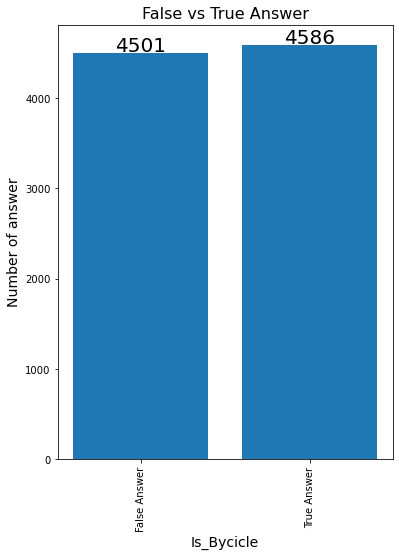

In [32]:
number_of_False = 0
number_of_True = 0

for item in references: # I am iterating each images
    
    if references[item].is_bicycle: # If the value is TRUE, I increment number_of_True
        number_of_True += 1
    else: # If the value is FALSE, I increment number_of_False
        number_of_False += 1

# I have put the number_of_False, number_of_True values inside numpy array
true_false_array = np.array([number_of_False, number_of_True])

print('Number of True values in References: {}'.format(true_false_array[1]))
print('Number of False values in References: {}'.format(true_false_array[0]))

# Here I am plotting the TRUE and FALSE answers in bar plot.

fig, ax = plt.subplots(figsize = (6,8))
ax.bar(np.arange(2), true_false_array)
plt.xticks(np.arange(2), ['False Answer', 'True Answer'], rotation='vertical')
for index,data in enumerate(true_false_array):
    plt.text(x=index-0.15 , y =data+20 , s=f"{data}" , fontdict=dict(fontsize=20))    
plt.xlabel("Is_Bycicle", size=14)
plt.ylabel("Number of answer", size=14)
plt.title("False vs True Answer", size=16)
plt.show()

# fig.savefig('FalseTrueAnswersReferences.png', bbox_inches='tight')

As we can see, we have 4586 True and 4501 False which is almost same so we have balanced dataset.

## Task 4.

To find the good or bad annotators, specifically in binary dataset, we could use confusion matrix, ROC, and AUC. 

In [21]:
# to calculate overall accuracy, I am using the below variables
overall_true_pos = 0
overall_false_pos = 0
overall_false_neg = 0
overall_true_neg = 0

# I made empty dictionary to find ROC and AUC for each annotator
fpr = dict()
tpr = dict()
roc_auc = dict()

for annotator in annotators_answer:
    true_pos = 0
    false_pos = 0
    false_neg = 0
    true_neg = 0
    
    # I am using an numpy array to restore answer and corresponding reference values
    annotators_answer[annotator]['answered_values'] = np.array([])
    annotators_answer[annotator]['reference_values'] = np.array([])
    
    # I iterate through the annotators answers with value and index 
    for idx, answer in enumerate(annotators_answer[annotator]['answer_list'], start=0):
        
        
        if answer == 'yes':
            # if the answer is YES, I save a TRUE value into the numpy list
            annotators_answer[annotator]['answered_values'] = np.append(annotators_answer[annotator]['answered_values']\
                                                                       ,True)
            
            # if the reference is also TRUE, then I increase true positive value otherwise I increase false positive
            if references[annotators_answer[annotator]['image_id'][idx]].is_bicycle:
                true_pos += 1
            else:
                false_pos += 1
                
        else:
            # if the answer is NO, I save a FALSE value into the numpy list
            annotators_answer[annotator]['answered_values'] = np.append(annotators_answer[annotator]['answered_values']\
                                                                       ,False)
            
            # if the reference is also FALSE, then I increase true negative value otherwise I increase false negative
            if not references[annotators_answer[annotator]['image_id'][idx]].is_bicycle:
                true_neg += 1                
            else:
                false_neg += 1
                
        # I add the reference value into a numpy array
        annotators_answer[annotator]['reference_values'] = np.append(annotators_answer[annotator]['reference_values'],\
                                                             references[annotators_answer[annotator]['image_id'][idx]].is_bicycle)
    
    # I am using sklearn's roc_curve function to find the false positive rate and true positive rate
    fpr[annotator], tpr[annotator], _ = roc_curve(annotators_answer[annotator]['reference_values'],\
                                                  annotators_answer[annotator]['answered_values'])
    
    # using the sklearn's auc function I am area under the ROC.
    roc_auc[annotator] = auc(fpr[annotator], tpr[annotator])
    
    annotators_answer[annotator]['true_pos'] = true_pos
    annotators_answer[annotator]['false_pos'] = false_pos
    annotators_answer[annotator]['true_neg'] = true_neg
    annotators_answer[annotator]['false_neg'] = false_neg
        
    overall_true_pos += true_pos
    overall_false_pos += false_pos
    overall_true_neg += true_neg
    overall_false_neg += false_neg
        

In [22]:
# I am writing the overall accuracy here.
overall_accuracy = (overall_true_pos+overall_true_neg)/(overall_true_pos+overall_false_pos\
                                                        +overall_false_neg+overall_true_neg)
print('Accuracy of overall answer {}'.format(overall_accuracy))

Accuracy of overall answer 0.934763948497854


We have 0.93 accuracy for overall annotators.

Next, I am calculating accuracy using the confusion matrix

In [23]:
for annotator in annotators_answer: 
    accuracy = (annotators_answer[annotator]['true_pos']+annotators_answer[annotator]['true_neg'])\
    /(annotators_answer[annotator]['true_pos']+annotators_answer[annotator]['false_pos']\
      +annotators_answer[annotator]['true_neg']+annotators_answer[annotator]['false_neg'])
    
    print('Accuracy of {} : {}'.format(annotator, accuracy))

Accuracy of annotator_01 : 0.9484375
Accuracy of annotator_02 : 0.9348341232227488
Accuracy of annotator_03 : 0.9285714285714286
Accuracy of annotator_04 : 0.9283600685251518
Accuracy of annotator_05 : 0.936978417266187
Accuracy of annotator_06 : 0.9265504965336331
Accuracy of annotator_07 : 0.9154022988505747
Accuracy of annotator_08 : 0.8993422059048494
Accuracy of annotator_09 : 0.9333333333333333
Accuracy of annotator_10 : 0.8888888888888888
Accuracy of annotator_11 : 0.9364512119328776
Accuracy of annotator_12 : 0.9297906602254429
Accuracy of annotator_13 : 0.9468776490534049
Accuracy of annotator_14 : 0.9466666666666667
Accuracy of annotator_15 : 0.9484231274638634
Accuracy of annotator_16 : 0.9423038925113614
Accuracy of annotator_17 : 0.9420373027259684
Accuracy of annotator_18 : 0.9367504835589942
Accuracy of annotator_19 : 0.9470588235294117
Accuracy of annotator_20 : 0.9482533463924258
Accuracy of annotator_21 : 0.94
Accuracy of annotator_22 : 0.9432664756446991


In [24]:
for annotator in annotators_answer: 
    precision = annotators_answer[annotator]['true_pos']\
    /(annotators_answer[annotator]['true_pos']+annotators_answer[annotator]['false_pos'])
    
    print('Precision of {} : {}'.format(annotator, precision))

Precision of annotator_01 : 0.9435364041604755
Precision of annotator_02 : 0.9392
Precision of annotator_03 : 0.9559322033898305
Precision of annotator_04 : 0.9240130602552686
Precision of annotator_05 : 0.9420871559633027
Precision of annotator_06 : 0.9017580144777663
Precision of annotator_07 : 0.9097345132743363
Precision of annotator_08 : 0.8930576070901034
Precision of annotator_09 : 0.922486879289463
Precision of annotator_10 : 0.84375
Precision of annotator_11 : 0.9499362244897959
Precision of annotator_12 : 0.9136133452487339
Precision of annotator_13 : 0.9485273091221047
Precision of annotator_14 : 0.9477958236658933
Precision of annotator_15 : 0.9579266240323123
Precision of annotator_16 : 0.9578482537133681
Precision of annotator_17 : 0.9634649381261049
Precision of annotator_18 : 0.9220440134278255
Precision of annotator_19 : 0.9438202247191011
Precision of annotator_20 : 0.9468503937007874
Precision of annotator_21 : 0.9348404255319149
Precision of annotator_22 : 0.9377123

In [25]:
for annotator in annotators_answer: 
    recall = (annotators_answer[annotator]['true_pos'])\
    /(annotators_answer[annotator]['true_pos']+annotators_answer[annotator]['false_neg'])
    
    print('Recall of {} : {}'.format(annotator, recall))

Recall of annotator_01 : 0.9577677224736049
Recall of annotator_02 : 0.9295328582739509
Recall of annotator_03 : 0.8980891719745223
Recall of annotator_04 : 0.9384986433524269
Recall of annotator_05 : 0.9329926178307779
Recall of annotator_06 : 0.9607051046639735
Recall of annotator_07 : 0.9261261261261261
Recall of annotator_08 : 0.9108165109972883
Recall of annotator_09 : 0.9453868431940422
Recall of annotator_10 : 0.9700598802395209
Recall of annotator_11 : 0.9220055710306406
Recall of annotator_12 : 0.9545596016184251
Recall of annotator_13 : 0.9442072302875035
Recall of annotator_14 : 0.9456018518518519
Recall of annotator_15 : 0.9377265238879736
Recall of annotator_16 : 0.9273221919937816
Recall of annotator_17 : 0.9211267605633803
Recall of annotator_18 : 0.9544401544401544
Recall of annotator_19 : 0.9545454545454546
Recall of annotator_20 : 0.9490299243669845
Recall of annotator_21 : 0.9468013468013468
Recall of annotator_22 : 0.9495412844036697


In [53]:
for annotator in annotators_answer: 
    recall = (annotators_answer[annotator]['true_pos'])\
    /(annotators_answer[annotator]['true_pos']+\
      0.5*(annotators_answer[annotator]['false_neg'] + annotators_answer[annotator]['false_pos']))
    
    print('F1 score of {} : {}'.format(annotator, recall))

F1 score of annotator_01 : 0.9505988023952096
F1 score of annotator_02 : 0.934341424592121
F1 score of annotator_03 : 0.9261083743842364
F1 score of annotator_04 : 0.9311995213879749
F1 score of annotator_05 : 0.9375178316690442
F1 score of annotator_06 : 0.930298719772404
F1 score of annotator_07 : 0.9178571428571428
F1 score of annotator_08 : 0.9018496420047732
F1 score of annotator_09 : 0.9337964854924398
F1 score of annotator_10 : 0.9025069637883009
F1 score of annotator_11 : 0.9357625255222239
F1 score of annotator_12 : 0.9336377473363775
F1 score of annotator_13 : 0.9463623395149786
F1 score of annotator_14 : 0.9466975666280417
F1 score of annotator_15 : 0.9477189477189477
F1 score of annotator_16 : 0.9423380726698263
F1 score of annotator_17 : 0.9418202764976958
F1 score of annotator_18 : 0.9379624359704041
F1 score of annotator_19 : 0.9491525423728814
F1 score of annotator_20 : 0.947938906224339
F1 score of annotator_21 : 0.9407828705252593
F1 score of annotator_22 : 0.94358974

From accuracy, we can see that annotator_01 and annotator_15 had 0.9484 which was the highest accuracy in the 4th floating digit. If we look at Precision, annotator_15 has higher value than annotator_01 which means that annotator_15 has answered images more correctly. On the other hand in Recall, annotator_01 has better score meaning that annotator_01 answered more images with bike in it. In F1 Score, Annotator 01 has the best score with 0.9505 while Annotator 15 has 0.9477.

Another thing to look in order to find out the better annotator is to look at ROC and AUC. The AUC from annotator_15 has same AUC was higher than annotator_01 so annotator_15 was quite qood overall.

On the other hand, Anotator_10 had the works accuracy, Precision and AUC so it was answering quite bad.

In [54]:
for annotator in roc_auc:
    print('AUC value of {} : {}'.format(annotator, roc_auc[annotator]))

AUC value of annotator_01 : 0.9480896959207571
AUC value of annotator_02 : 0.9348215906814987
AUC value of annotator_03 : 0.9284749657340966
AUC value of annotator_04 : 0.9280122082741515
AUC value of annotator_05 : 0.93703306504141
AUC value of annotator_06 : 0.9258383977795767
AUC value of annotator_07 : 0.915175739119401
AUC value of annotator_08 : 0.8991621398988927
AUC value of annotator_09 : 0.933397473991618
AUC value of annotator_10 : 0.883678588768409
AUC value of annotator_11 : 0.9365098057961314
AUC value of annotator_12 : 0.9288980857608308
AUC value of annotator_13 : 0.9468581733485204
AUC value of annotator_14 : 0.9466685217447413
AUC value of annotator_15 : 0.948391594731409
AUC value of annotator_16 : 0.9425598098232573
AUC value of annotator_17 : 0.94243472531093
AUC value of annotator_18 : 0.936716201251085
AUC value of annotator_19 : 0.9467849223946784
AUC value of annotator_20 : 0.9482588843877063
AUC value of annotator_21 : 0.9399535744245642
AUC value of annotator

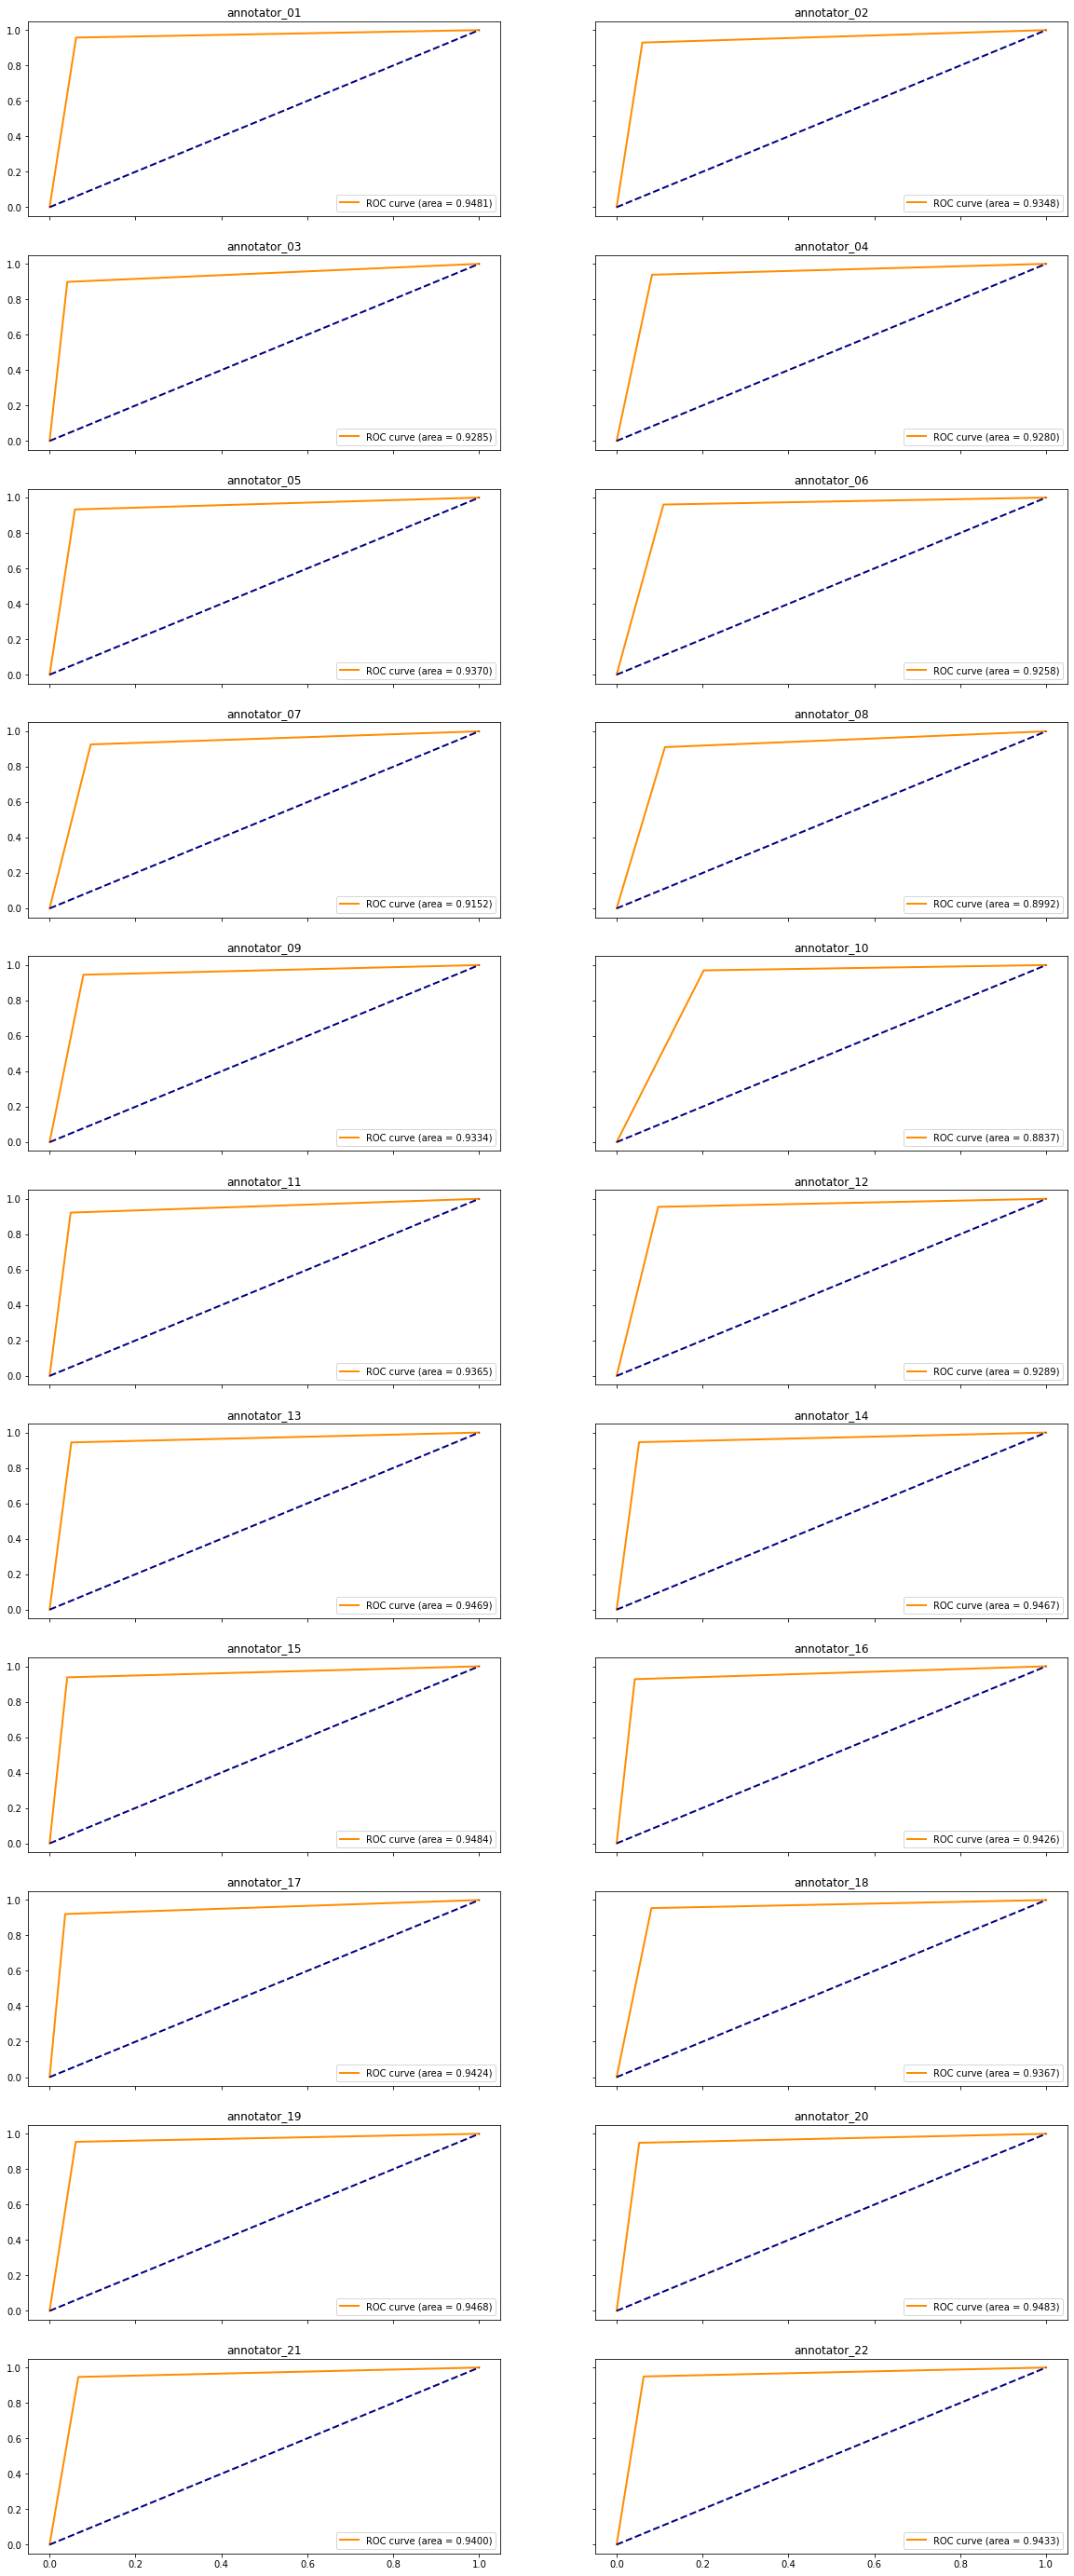

In [33]:
fig, axs = plt.subplots(11, 2, sharex=True, sharey=True, figsize=(20, 50))

row_idx = 0
col_idx = 0

for annotator in fpr:
    lw = 2
    
    axs[row_idx, col_idx].plot(fpr[annotator], tpr[annotator], color='darkorange',
             lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[annotator])
    axs[row_idx, col_idx].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axs[row_idx, col_idx].legend(loc="lower right")
    axs[row_idx, col_idx].set_title(annotator)
    
    if col_idx == 0:
        col_idx += 1
    else:
        col_idx = 0    
        row_idx += 1
        
# fig.savefig('ROCCurve.png', bbox_inches='tight')